In [14]:
import robotic as ry
import time
import numpy as np
def find_rrt_path(C, start_joint, goal_joint):
    print(f"Running RRT from {start_joint} to {goal_joint}...")
    ry.params_clear()
    ry.params_add({'rrt/stepsize':.1, 'rrt/verbose': 0,'rrt/maxIters':15000}) #verbose=3 makes it very slow, and displays result, and verbose=4 waits keypress..
    rrt_solver = ry.PathFinder()
    rrt_solver.setProblem(C, [start_joint], [goal_joint])  
    result = rrt_solver.star_solve()
    if result is not None and result.x is not None:
        print("Feasible path found!")
        return result 
    else:
        print("No feasible path found.")
        find_rrt_path(C, start_joint, goal_joint)


  *** Credits ***
  * In operation mode `OneshotPlanner` at line 112 of `/tmp/ipykernel_75596/559042396.py`, you are using the following planning engine:
  * Engine name: pyperplan
  * Developers:  Albert-Ludwigs-Universität Freiburg (Yusra Alkhazraji, Matthias Frorath, Markus Grützner, Malte Helmert, Thomas Liebetraut, Robert Mattmüller, Manuela Ortlieb, Jendrik Seipp, Tobias Springenberg, Philip Stahl, Jan Wülfing)
  * Description: Pyperplan is a lightweight STRIPS planner written in Python.

Plan found:
pick(tray1, table1, l_gripper)
place(tray1, bin, l_gripper)
allow_next_pick(tray2)
pick(tray2, table1, l_gripper)
allow_next_pick(mug)
place(tray2, bin, l_gripper)
pick(mug, table1, l_gripper)
place(mug, bin, l_gripper)
allow_wiping
wipe(table1, l_gripper)


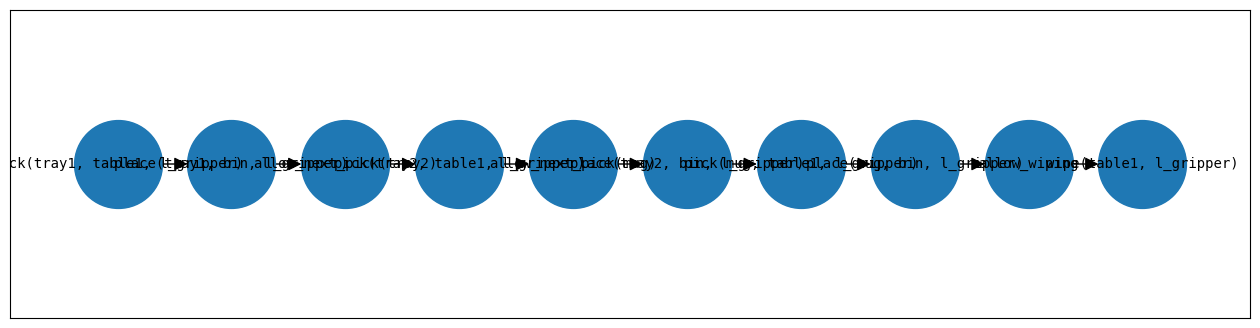

In [15]:
from unified_planning.shortcuts import *
from unified_planning.plot import plot_sequential_plan

# Define User Types
Location = UserType("Location")
Object = UserType("Object")
Tool = UserType("Tool")


# Define Objects
tray1 = unified_planning.model.Object("tray1", Object)
tray2 = unified_planning.model.Object("tray2", Object)
mug = unified_planning.model.Object("mug", Object)
sponge = unified_planning.model.Object("sponge", Tool)
l_gripper = unified_planning.model.Object("l_gripper", Tool)
table1 = unified_planning.model.Object("table1", Location)
bin = unified_planning.model.Object("bin", Location)
dustbin = unified_planning.model.Object("dustbin", Location)


# Define Fluents
on = Fluent("on", BoolType(), obj=Object, loc=Location)
holding = Fluent("holding", BoolType(), tool=Tool)
ready_to_pick = Fluent("ready_to_pick", BoolType(), obj=Object)
needs_processing = Fluent("needs_processing", BoolType(), obj=Object)  
dirty = Fluent("dirty", BoolType(), loc=Location)
clean = Fluent("clean", BoolType(), loc=Location)
wiping_allowed = Fluent("wiping_allowed", BoolType())
usable_tool = Fluent("usable_tool", BoolType(), obj=Object, tool=Tool)

# Define Actions
pick = InstantaneousAction("pick", obj=Object, loc=Location, tool=Tool)
pick_obj, pick_loc, pick_tool = pick.parameters
pick.add_precondition(on(pick_obj, pick_loc))  
pick.add_precondition(ready_to_pick(pick_obj)) 
pick.add_precondition(usable_tool(pick_obj, pick_tool)) 
pick.add_precondition(needs_processing(pick_obj))  
pick.add_effect(on(pick_obj, pick_loc), False)  
pick.add_effect(holding(pick_tool), True)  

place = InstantaneousAction("place", obj=Object, loc=Location, tool=Tool)
place_obj, place_loc, place_tool = place.parameters
place.add_precondition(holding(place_tool))  
place.add_precondition(needs_processing(place_obj))  
place.add_effect(holding(place_tool), False)  
place.add_effect(on(place_obj, place_loc), True)  
place.add_effect(needs_processing(place_obj), False)  

allow_next_pick = InstantaneousAction("allow_next_pick", obj=Object)
allow_next_pick_obj = allow_next_pick.parameter("obj")
allow_next_pick.add_precondition(needs_processing(allow_next_pick_obj))  
allow_next_pick.add_precondition(on(tray1, bin))  
allow_next_pick.add_effect(ready_to_pick(allow_next_pick_obj), True)  

allow_wiping = InstantaneousAction("allow_wiping")
allow_wiping.add_precondition(on(tray1, bin))
allow_wiping.add_precondition(on(tray2, bin))
allow_wiping.add_precondition(on(mug, bin))
allow_wiping.add_effect(wiping_allowed, True)  

wipe = InstantaneousAction("wipe", loc=Location, tool=Tool)
wipe_loc, wipe_tool = wipe.parameters
wipe.add_precondition(dirty(wipe_loc))  
wipe.add_precondition(wiping_allowed)  
wipe.add_effect(dirty(wipe_loc), False)  
wipe.add_effect(clean(wipe_loc), True)  

# Define Problem
problem = Problem("table_cleaning")
problem.add_fluent(on, default_initial_value=False)
problem.add_fluent(holding, default_initial_value=False)
problem.add_fluent(ready_to_pick, default_initial_value=False)
problem.add_fluent(needs_processing, default_initial_value=False)
problem.add_fluent(dirty, default_initial_value=False)
problem.add_fluent(clean, default_initial_value=False)
problem.add_fluent(wiping_allowed, default_initial_value=False)
problem.add_fluent(usable_tool, default_initial_value=False)

problem.add_action(pick)
problem.add_action(place)
problem.add_action(allow_next_pick)
problem.add_action(allow_wiping)
problem.add_action(wipe)

problem.add_objects([tray1, tray2, mug, sponge, l_gripper, table1, bin, dustbin])

# Define Initial State
problem.set_initial_value(on(tray1, table1), True)
problem.set_initial_value(on(tray2, table1), True)
problem.set_initial_value(on(mug, table1), True)
problem.set_initial_value(dirty(table1), True)
problem.set_initial_value(holding(l_gripper), False)
problem.set_initial_value(holding(sponge), False)
problem.set_initial_value(wiping_allowed, False)
problem.set_initial_value(ready_to_pick(tray1), True)  
problem.set_initial_value(needs_processing(tray1), True)
problem.set_initial_value(needs_processing(tray2), True)
problem.set_initial_value(needs_processing(mug), True)

# Tool Constraints
problem.set_initial_value(usable_tool(tray1, l_gripper), True)
problem.set_initial_value(usable_tool(tray2, l_gripper), True)
problem.set_initial_value(usable_tool(mug, l_gripper), True)

# Define Goals
problem.add_goal(on(tray1, bin))
problem.add_goal(on(tray2, bin))
problem.add_goal(on(mug, bin))
problem.add_goal(clean(table1))

# Solve the Problem
with OneshotPlanner(name="pyperplan") as planner:
    result = planner.solve(problem)
    if result.status == up.engines.PlanGenerationResultStatus.SOLVED_SATISFICING:
        print("Plan found:")
        for action in result.plan.actions:
            print(action)
        plan = result.plan
        if plan is not None:
            plot_sequential_plan(plan, figsize=(16, 4), node_size=4000, font_size=10)
    else:
        print("No plan found.")


In [16]:
if plan: 
    C = ry.Config()
    C.addFile(ry.raiPath('../rai-robotModels/task.g'))  

    for action_instance in plan.actions:
        action_name = action_instance.action.name
        parameters = action_instance.actual_parameters

        if action_name == "pick":
            obj, loc, tool = [str(p.object()) for p in parameters]
            if loc == "table1":  
                loc_frame = C.frame(loc)
                tool_frame = C.frame(tool)
                start_joint = C.getJointState()
                obj_frame = C.frame(obj) 
                C.view()
                C.setJointState(start_joint)
                komo = ry.KOMO(C, 5, 10, 1, True)
                komo.addControlObjective([], 0, 1e-1)
                komo.addControlObjective([], 1, 1e0)
                komo.addObjective([1], ry.FS.positionDiff, ['l_gripper', obj], ry.OT.eq, [1e1])
                ret = ry.NLP_Solver(komo.nlp(), verbose=0 ) .solve()
                C.setJointState(start_joint)
                goal_joint = komo.getPath()[-1]
                C.view()
                print(f"Executing 'pick': Moving tool '{tool}' to pick object '{obj}' from '{loc}'")
                rrt_path = find_rrt_path(C, [start_joint], [goal_joint])
                if rrt_path.feasible:
                    path = rrt_path.x
                    for i in range(len(path)):
                        print('position: ', path[i] )
                        C.setJointState(path[i])
                        C.view()
                        time.sleep(0.1)
        elif action_name == "place":
            obj, loc, tool = [str(p.object()) for p in parameters]
            if loc in ["bin1", "dustbin"]:  
                loc_frame = C.frame(loc)
                tool_frame = C.frame(tool)
                start_joint = C.getJointState()
                loc_frame = C.frame(loc)
                goal_position = loc_frame.getPosition()
                IK_goal = tool_frame.setPosition(goal_position)
                goal_joint = C.getJointState()  

                print(f"Executing 'place': Moving tool '{tool}' to place object '{obj}' at '{loc}'")
                rrt_path = find_rrt_path(C, [start_joint], [goal_joint])
                if rrt_path.feasible:
                    path = rrt_path.x
                    for i in range(len(path)):
                        print('position: ', path[i] )
                        C.setJointState(path[i])
                        C.view()
                        time.sleep(0.1)

        elif action_name == "wipe":
            loc, tool = [str(p.object()) for p in parameters]
            if loc == "table1":  
                loc_frame = C.frame(loc)
                tool_frame = C.frame(tool)
                start_joint = C.getJointState()
                goal_position = loc_frame.getPosition()
                IK_goal = tool_frame.setPosition(goal_position)
                goal_joint = C.getJointState()  

                print(f"Executing 'wipe': Moving tool '{tool}' to wipe location '{loc}'")
                rrt_path = find_rrt_path(C, [start_joint], [goal_joint])
                if rrt_path.feasible:
                    path = rrt_path.x
                    for i in range(len(path)):
                        print('position: ', path[i] )
                        C.setJointState(path[i])
                        C.view()
                        time.sleep(0.1)

        elif action_name == "allow_wiping":
            print("Executing 'allow_wiping': Logical action to enable wiping. No physical movement required.")
            time.sleep(1)  
        break

-- WARNING:Executing 'pick': Moving tool 'l_gripper' to pick object 'tray1' from 'table1'
Running RRT from [array([ 0. , -0.5,  0. , -2. ,  0. ,  2. , -0.5])] to [array([-6.71548825e-01,  3.47149960e-01, -1.50401764e-01, -1.39480318e+00,
        1.59629162e-03,  2.40806629e+00, -4.99210227e-01])]...
RenderData.cpp:glInitialize:105(-1) FreeType Error: Failed to load font 'ubuntu/Ubuntu-L.ttf' error code: 1 -> text rendering disabled
entered RRT_Star_PathFinder
entered run
entered planConnect
execution completed
before path
after path
after pathT
viable path found
done and now I will add stuff
Star solve completed!
Feasible path found!
position:  [ 0.  -0.5  0.  -2.   0.   2.  -0.5]
position:  [-0.02006401 -0.42638658  0.0094321  -1.95188414 -0.03835064  2.00714388
 -0.48410683]
position:  [-0.07288486 -0.36367006 -0.00352686 -1.90671732 -0.03511184  2.03964972
 -0.48533138]
position:  [-0.12570572 -0.30095354 -0.01648581 -1.86155051 -0.03187304  2.07215557
 -0.48655592]
position:  [-0.1

In [ ]:
C.getFrameNames()
table1 = C.getFrame('table1')
print(table1.getPosition())

In [12]:
if plan: 
    C = ry.Config()
    C.addFile(ry.raiPath('../rai-robotModels/task.g'))  

    for action_instance in plan.actions:
        action_name = action_instance.action.name
        parameters = action_instance.actual_parameters

        if action_name == "pick":
            obj, loc, tool = [str(p.object()) for p in parameters]
            if loc == "table1":  
                loc_frame = C.frame(loc)
                tool_frame = C.frame(tool)
                start_joint = C.getJointState()
                obj_frame = C.frame(obj) 
                C.view()
                C.setJointState(start_joint)
                komo = ry.KOMO(C, 5, 10, 1, True)
                komo.addControlObjective([], 0, 1e-1)
                komo.addControlObjective([], 1, 1e0)
                komo.addObjective([1], ry.FS.positionDiff, ['l_gripper', 'tray1'], ry.OT.eq, [1e1])
                ret = ry.NLP_Solver(komo.nlp(), verbose=0 ) .solve()
                C.setJointState(start_joint)
                goal_joint = komo.getPath()[-1]
                C.view()
                print(f"Executing 'pick': Moving tool '{tool}' to pick object '{obj}' from '{loc}'")
                rrt_path = find_rrt_path(C, [start_joint], [goal_joint])
                if rrt_path.feasible:
                    path = rrt_path.x
                    for i in range(len(path)):
                        print('position: ', path[i] )
                        C.setJointState(path[i])
                        C.view()
                        time.sleep(0.1)
       
        break


-- WARNING:RenderData.cpp:glInitialize:105(-1) FreeType Error: Failed to load font 'ubuntu/Ubuntu-L.ttf' error code: 1 -> text rendering disabled
Executing 'pick': Moving tool 'l_gripper' to pick object 'tray1' from 'table1'
Running RRT from [array([ 0. , -0.5,  0. , -2. ,  0. ,  2. , -0.5])] to [array([-6.71652120e-01,  3.48148471e-01, -1.50648366e-01, -1.39430196e+00,
        2.04537828e-03,  2.40854191e+00, -5.00043909e-01])]...
entered RRT_Star_PathFinder
normal solve completed!
Feasible path found!
position:  [ 0.  -0.5  0.  -2.   0.   2.  -0.5]
position:  [-0.05332956 -0.43411442 -0.00293664 -1.95379705  0.008968    2.02247182
 -0.49070999]
position:  [-0.10418463 -0.36977577 -0.01508546 -1.90778035  0.00839864  2.05422486
 -0.49147768]
position:  [-0.18217707 -0.3921633   0.02695657 -1.88875821 -0.01568919  2.0350505
 -0.47307318]
position:  [-0.23074221 -0.32400546  0.01804675 -1.84240504 -0.00774605  2.06142219
 -0.47001132]
position:  [-0.28121752 -0.25481338  0.01555282 -1.7

In [13]:
C = ry.Config()
C.addFile(ry.raiPath('../rai-robotModels/task.g'))  
C.view()
time.sleep(1)
C.setJointState(start_joint)
komo = ry.KOMO(C, 1, 10, 1, True)
komo.addControlObjective([], 0, 1e-1)
komo.addControlObjective([], 1, 1e0)
komo.addObjective([1], ry.FS.positionDiff, ['l_gripper', 'tray1'], ry.OT.eq, [1e1])

ret = ry.NLP_Solver(komo.nlp(), verbose=0 ) .solve()
print(ret)
q = komo.getPath()
print(q)
for t in range(q.shape[0]):
    C.setJointState(q[t])
    C.view(False, f'waypoint {t}')
    time.sleep(.1)

-- WARNING:RenderData.cpp:glInitialize:105(-1) FreeType Error: Failed to load font 'ubuntu/Ubuntu-L.ttf' error code: 1 -> text rendering disabled
{ time: 0.06712, evals: 235, done: 1, feasible: 0, eq: 3.42892, ineq: 0, sos: 10.2378, f: 0 }
[[-1.53467133e-01 -3.02922769e-01 -2.79686720e-02 -1.85112863e+00
   4.36139725e-04  2.09374772e+00 -5.00002238e-01]
 [-3.07132925e-01 -1.05569285e-01 -5.59085256e-02 -1.70198885e+00
   8.54882433e-04  2.18761549e+00 -5.00004425e-01]
 [-4.61195579e-01  9.23361075e-02 -8.37912673e-02 -1.55231319e+00
   1.23790774e-03  2.28172311e+00 -5.00006513e-01]
 [-6.15852394e-01  2.91067900e-01 -1.11589655e-01 -1.40183599e+00
   1.56504027e-03  2.37618987e+00 -5.00008456e-01]
 [-7.71299372e-01  4.90898935e-01 -1.39278024e-01 -1.25029421e+00
   1.81330084e-03  2.47113441e+00 -5.00010209e-01]
 [-9.27730858e-01  6.92100027e-01 -1.66832818e-01 -1.09742805e+00
   1.95592959e-03  2.56667448e+00 -5.00011735e-01]
 [-1.08533927e+00  8.94939752e-01 -1.94233121e-01 -9.42981